# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [57]:
from __future__ import print_function
from pprint import pprint

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# set this to an empty string ("") to display the outputted videos, otherwise the videos online will be shown
videos_basepath = ""

## Read in an Image

In [58]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [59]:
def intersection(line0, line1):
    """Find the point where two lines intersect
    
    Parameters
    ----------
    line0 : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    line1 : numpy.ndarray
        two points that define a line (same as ``line0``)
        
    Returns
    -------
    numpy.ndarray
        the point where ``line0`` and ``line1`` intersect -- ``[x, y]``
    
    """
    # \Delta x and \Delta y
    dx0 = line0[0][2] - line0[0][0]
    dy0 = line0[0][3] - line0[0][1]
    dx1 = line1[0][2] - line1[0][0]
    dy1 = line1[0][3] - line1[0][1]
    
    # A [x, y]^T = b
    A = np.array([[dy0, -dx0], [dy1, -dx1]])
    b = np.array([line0[0][0]*dy0 - line0[0][1]*dx0, line1[0][0]*dy1 - line1[0][1]*dx1])
    
    return np.round(np.linalg.solve(A, b))#.astype(np.uint16)


def find_x_given_y(line, y):
    """Given a line, solve for x when y is specified
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y : float
        we want to find x such that (x, y) is on the line
        
    Returns
    -------
    numpy.ndarray
        ``[x, y]``, where x is such that (x, y) is on the line
    
    """
    dx = line[0][2] - line[0][0]
    dy = line[0][3] - line[0][1]
    
    return np.round(np.array([line[0][0] + (y - line[0][1])*dx/dy, y]))#.astype(np.uint16)


def intersection_or_ymax(line0, line1, y_const):
    """Given two lines, return whichever points are lower: their intersection with each other
    or their intersection with the line y=y_const
    
    Parameters
    ----------
    line0 : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    line1 : numpy.ndarray
        two points that define a line (same as ``line0``)
    y_const : float
        we will find the intersections of ``line0`` and ``line1`` with the line y=y_const
        
    Returns
    -------
    numpy.ndarray
        the point ``[x, y]`` where ``line0`` intersects ``line1`` OR where ``line0`` intersects y=y_const
    numpy.ndarray
        same as xy0, except for ``line1``
    
    """
    # point where the lines intersect each other
    xy = intersection(line0, line1)
    
    if xy[1] > y_const:
        return xy, xy
    else:
        return find_x_given_y(line0, y_const), find_x_given_y(line1, y_const)
    
    
def extend_to_bottom_top(line, y_bottom, y_top):
    """Extend ``line`` to the bottom and top of the masked image
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y_bottom : float
        we will find the intersection of ``line`` with the line y=y_bottom
    y_top : float
        we will find the intersection of ``line`` with the line y=y_top
        
    Returns
    -------
    numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``, where ``y0 = y_bottom``
        and ``y1 = y_top``
        
    """
    # find the points on the bottom and top
    xy_bottom = find_x_given_y(line, y_bottom)
    xy_top = find_x_given_y(line, y_top)
    
    return np.array([[xy_bottom[0], xy_bottom[1], xy_top[0], xy_top[1]]])


def extend_to_bottom(line, y_bottom):
    """Extend ``line`` to the bottom of the masked image
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y_bottom : float
        we will find the intersection of ``line`` with the line y=y_bottom
        
    Returns
    -------
    numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``, where ``y0 = y_bottom``
        
    """
    # find the points on the bottom and top
    xy_bottom = find_x_given_y(line, y_bottom)
    
    if line[0][1] > line[0][3]:
        return np.array([[xy_bottom[0], xy_bottom[1], line[0][2], line[0][3]]])
    else:
        return np.array([[xy_bottom[0], xy_bottom[1], line[0][0], line[0][1]]])
    
    
def get_slope(line):
    """Get the slope of the line
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
        
    Returns
    -------
    float
        the slope of the line
        
    """
    if np.abs(float(line[0][2]) - float(line[0][0])) < 1e-6:
        return 1e6
    else:
        return (float(line[0][3]) - float(line[0][1])) / (float(line[0][2]) - float(line[0][0]))

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [60]:
def process_image(image):
    """Draw the lane lines on an image
    
    Parameters
    ----------
    image : 
        the input image (RGB)
        
    Returns
    -------
    lines_edges : 
        the input image with lane lines drawn on (RGB)
        
    """    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # get the image dimensions
    rows, cols = gray.shape
    
    ### STEP 1: apply Gaussian blur
    kernel_size = (5, 5)
    blur_gray = cv2.GaussianBlur(gray, kernel_size, 0)
    
    ### STEP 2: Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    ### STEP 3: apply a mask to the image
    # parameters for the image mask and for filtering lines
    left = 0.12*cols
    right = 0.94*cols
    top = 0.55*rows
    top_width = 0.05*cols
    
    # parameters for filtering lines
    left_min = left
    left_max = 0.2*cols
    right_min = 0.86*cols
    right_max = right
    
    # a mask to be applied to the image
    top_left = (left + right - top_width)/2
    top_right = (left + right + top_width)/2
    vertices = np.array([[(left, rows), (top_left, top), (top_right, top), (right, rows)]],
                        dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 200 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments  

    # initialize ``good_lines`` for the purpose of the while loop
    good_lines = []
    
    # adjust Hough transform parameters until we only get two lines
    while len(good_lines) != 2 and threshold > 0:
        ### STEP 4: apply the Hough Transform on the ``masked_edges`` image
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)

        ### STEP 5: process and filter the lines found by the Hough transform
        # sort the lines by their length
        lines = sorted(lines, key=lambda x: np.linalg.norm(x[2:] - x[:2]), reverse=True)
        
        # extend the lines to the bottom and top of the masked image
        lines = [extend_to_bottom_top(line, rows, top) for line in lines]

        # filter out lines based on their x-coordinates at the bottom and top of the masked image
        lines = [line for line in lines
                 if ((left_min <= line[0][0] <= left_max or right_min <= line[0][0] <= right_max) and
                     0.4*cols <= line[0][2] <= 0.7*cols)]

        # if we have more than 1 line, try to choose two lines
        if len(lines) > 1:
            # the first line is the longest line ==> calculate its slope
            m0 = get_slope(lines[0])

            # the second line is the longest line with opposite slope of the first line
            for line in lines:
                m1 = get_slope(line)
                if np.sign(m1) != np.sign(m0):
                    # remove "bad" entries in ``lines``
                    good_lines = [lines[0], line]

                    # get the top endpoints of the lines
                    xy0, xy1 = intersection_or_ymax(good_lines[0], good_lines[1], top)            
                    good_lines[0][0][2:] = xy0
                    good_lines[1][0][2:] = xy1
                    break
        
        # if we didn't find two good lines, then cut the Hough parameters in half and repeat
        threshold //= 2
        min_line_length /= 2
        max_line_gap /= 2
    
    # Iterate over the output "lines" and draw lines on a blank image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    for line in good_lines:
        for x1,y1,x2,y2 in line.astype(np.uint16):
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return lines_edges

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidWhiteCurve.jpg


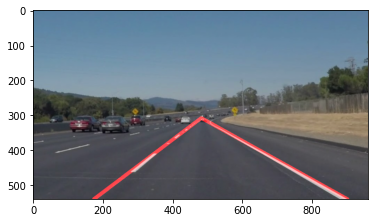

solidWhiteRight.jpg


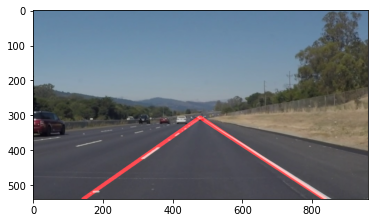

solidYellowCurve.jpg


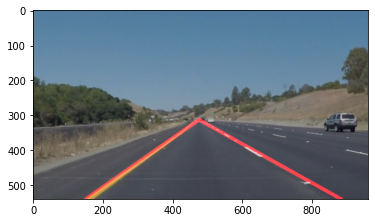

solidYellowCurve2.jpg


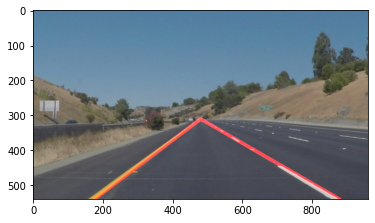

solidYellowLeft.jpg


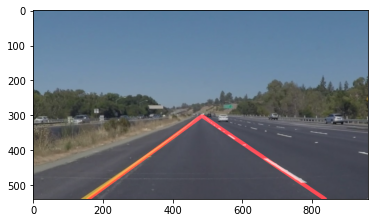

whiteCarLaneSwitch.jpg


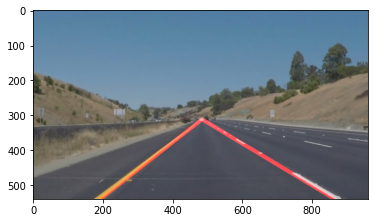

In [61]:
import os
test_image_dir = "test_images/"
test_images = os.listdir(test_image_dir)

for img in test_images:
    print(img)
    image = mpimg.imread(test_image_dir + img)
    plt.imshow(process_image(image))
    plt.show()



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [62]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 2/221 [00:00<00:13, 16.43it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 5.58 s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}{1}">
</video>
""".format(videos_basepath, white_output))

In [64]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 2/681 [00:00<00:34, 19.67it/s, now=None]Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 13.6 s


Let's try the one with the solid white lane on the right first ...

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}{1}">
</video>
""".format(videos_basepath, yellow_output))

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [66]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|          | 2/251 [00:00<00:22, 11.23it/s, now=None]Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 11 s


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [67]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}{1}">
</video>
""".format(videos_basepath, challenge_output))

In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

NameError: name 'grayscale' is not defined